In [1]:
import cx_Oracle
from IPython.display import IFrame    #to display pdf file
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
from py2casefold import casefold
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Project starts here

# Step1: Get Full calendar year data for each year, and store them in three dataframes

In [2]:
#2YL
host = 'tncluster6.cbi.net'
port = 1521
s_name = 'EDW1TS_EX.cbi.net'
dsn_tns = cx_Oracle.makedsn(host, port, service_name = s_name)
db_ts = cx_Oracle.connect('amartinezcotto', 'Kohlia#743', dsn_tns)
cursor = db_ts.cursor()

query =  '''select /*+ parallel(6) */ a14.TDLINX_STORE_CD  RTL_TDLINX_STORE_CD,
 a14.STORE_CD  RTL_STORE_CD,
 max(a14.CHANNEL_DSC)  RTL_CHANNEL_DSC,
 a14.SUBCHANNEL_DSC  RTL_SUBCHANNEL_DSC,
 max(a14.STORE_STTS_DSC)  RTL_STORE_STTS_DSC,
 max(a14.PREMISE_TYPE_DSC)  RTL_PREMISE_TYPE_DSC,
 a14.ADDR_01_DSC  RTL_ADDR_01_DSC,
 sum(a11.EQV_QTY)  EQV_QTY_YA2
from EDW.BI_CRN_F_RETAIL_DEPL_MVW_VW a11
 join EDW.BI_L_DT_XFORM_CY_VW a12
   on  (a11.DATE_ID = a12.CY_DT_ID)
 join EDW.BI_D_DATE_VW a13
   on  (a12.DATE_ID = a13.LAST_2YR_DT_ID)
 join EDW.BI_CRN_D_RETAILER_VW a14
   on  (a11.RETAILER_ID = a14.RETAILER_ID)
 join EDW.BI_CRN_D_DISTRIBUTOR_VW a15
   on  (a11.DIST_ID = a15.DIST_ID)
 join EDW.BI_D_DATE_VW a16
   on  (a13.DATE_ID = a16.DATE_ID)
where (a16.CBBD_BUSI_DAYS_NUM = 2
 and a15.STATE_PROVINCE_COUNTRY_CD in ('162'))
group by a14.TDLINX_STORE_CD,
 a14.STORE_CD,
 a14.SUBCHANNEL_CD,
 a14.SUBCHANNEL_DSC,
 a14.STORE_STTS_CD,
 a14.ADDR_01_DSC,
 a14.PREMISE_TYPE_CD,
 a14.CHANNEL_CD 
order by a14.TDLINX_STORE_CD
'''

try:
    cursor.execute(query)
    names = [ x[0] for x in cursor.description]
    rows = cursor.fetchall()
    YA2_DF = pd.DataFrame(rows, columns=names)

finally:
    if cursor is not None:
        cursor.close()

YA2_DF.head()

,RTL_TDLINX_STORE_CD,RTL_STORE_CD,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_STORE_STTS_DSC,RTL_PREMISE_TYPE_DSC,RTL_ADDR_01_DSC,EQV_QTY_YA2
0,0090292,100090292,GROCERY,SUPERMARKET-CONVENTIONAL,CLOSED STORE,OFF PREMISE,112 OAK ST,106.4999
1,0090293,100090293,GROCERY,SUPERMARKET-CONVENTIONAL,OPEN STORE,OFF PREMISE,501 COMMERCIAL DR,53.0000
2,0090308,100090308,GROCERY,SUPERETTE,OPEN STORE,OFF PREMISE,403 E MARKET ST,10.0000
3,0090317,200090317,GROCERY,SUPERMARKET-CONVENTIONAL,OPEN STORE,OFF PREMISE,1740 MASSACHUSETTS AVE,51.0000
4,0090323,100090323,GROCERY,SUPERMARKET-CONVENTIONAL,OPEN STORE,OFF PREMISE,2300 LOUISIANA ST,23.0000


In [4]:
#YA
host = 'tncluster6.cbi.net'
port = 1521
s_name = 'EDW1TS_EX.cbi.net'
dsn_tns = cx_Oracle.makedsn(host, port, service_name = s_name)
db_ts = cx_Oracle.connect('amartinezcotto', 'Kohlia#743', dsn_tns)
cursor = db_ts.cursor()

query =  ''' select /*+ parallel(6) */ a14.TDLINX_STORE_CD  RTL_TDLINX_STORE_CD,
 a14.STORE_CD  RTL_STORE_CD,
 max(a14.CHANNEL_DSC)  RTL_CHANNEL_DSC,
 a14.SUBCHANNEL_DSC  RTL_SUBCHANNEL_DSC,
 max(a14.STORE_STTS_DSC)  RTL_STORE_STTS_DSC,
 max(a14.PREMISE_TYPE_DSC)  RTL_PREMISE_TYPE_DSC,
 a14.ADDR_01_DSC  RTL_ADDR_01_DSC,
 sum(a11.EQV_QTY)  EQV_QTY_YA
from EDW.BI_CRN_F_RETAIL_DEPL_MVW_VW a11
 join EDW.BI_L_DT_XFORM_CY_VW a12
   on  (a11.DATE_ID = a12.CY_DT_ID)
 join EDW.BI_D_DATE_VW a13
   on  (a12.DATE_ID = a13.LAST_YR_DT_ID)
 join EDW.BI_CRN_D_RETAILER_VW a14
   on  (a11.RETAILER_ID = a14.RETAILER_ID)
 join EDW.BI_CRN_D_DISTRIBUTOR_VW a15
   on  (a11.DIST_ID = a15.DIST_ID)
 join EDW.BI_D_DATE_VW a16
   on  (a13.DATE_ID = a16.DATE_ID)
where (a16.CBBD_BUSI_DAYS_NUM = 2
 and a15.STATE_PROVINCE_COUNTRY_CD in ('162'))
group by a14.TDLINX_STORE_CD,
 a14.STORE_CD,
 a14.SUBCHANNEL_CD,
 a14.SUBCHANNEL_DSC,
 a14.STORE_STTS_CD,
 a14.ADDR_01_DSC,
 a14.PREMISE_TYPE_CD,
 a14.CHANNEL_CD  
order by a14.TDLINX_STORE_CD'''

try:
    cursor.execute(query)
    names = [ x[0] for x in cursor.description]
    rows = cursor.fetchall()
    YA_DF = pd.DataFrame(rows, columns=names)

finally:
    if cursor is not None:
        cursor.close()

YA_DF.head()

,RTL_TDLINX_STORE_CD,RTL_STORE_CD,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_STORE_STTS_DSC,RTL_PREMISE_TYPE_DSC,RTL_ADDR_01_DSC,EQV_QTY_YA
0,0090293,100090293,GROCERY,SUPERMARKET-CONVENTIONAL,OPEN STORE,OFF PREMISE,501 COMMERCIAL DR,72.0000
1,0090308,100090308,GROCERY,SUPERETTE,OPEN STORE,OFF PREMISE,403 E MARKET ST,5.0000
2,0090317,200090317,GROCERY,SUPERMARKET-CONVENTIONAL,OPEN STORE,OFF PREMISE,1740 MASSACHUSETTS AVE,137.0000
3,0090323,100090323,GROCERY,SUPERMARKET-CONVENTIONAL,OPEN STORE,OFF PREMISE,2300 LOUISIANA ST,194.9993
4,0090339,100090339,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,OPEN STORE,OFF PREMISE,1031 METROPOLITAN ST,8.0000


In [5]:
#TY

host = 'tncluster6.cbi.net'
port = 1521
s_name = 'EDW1TS_EX.cbi.net'
dsn_tns = cx_Oracle.makedsn(host, port, service_name = s_name)
db_ts = cx_Oracle.connect('amartinezcotto', 'Kohlia#743', dsn_tns)
cursor = db_ts.cursor()

query =  ''' select /*+ parallel(6) */  a13.TDLINX_STORE_CD  RTL_TDLINX_STORE_CD,
 a13.STORE_CD  RTL_STORE_CD,
 max(a13.CHANNEL_DSC)  RTL_CHANNEL_DSC,   
 a13.SUBCHANNEL_DSC  RTL_SUBCHANNEL_DSC,
 max(a13.STORE_STTS_DSC)  RTL_STORE_STTS_DSC,
 max(a13.PREMISE_TYPE_DSC)  RTL_PREMISE_TYPE_DSC,
 a13.ADDR_01_DSC  RTL_ADDR_01_DSC,
 sum(a11.EQV_QTY)  EQV_QTY_TY
from EDW.BI_CRN_F_RETAIL_DEPL_MVW_VW a11
 join EDW.BI_L_DT_XFORM_CY_VW a12
   on  (a11.DATE_ID = a12.CY_DT_ID)
 join EDW.BI_CRN_D_RETAILER_VW a13
   on  (a11.RETAILER_ID = a13.RETAILER_ID)
 join EDW.BI_CRN_D_DISTRIBUTOR_VW a14
   on  (a11.DIST_ID = a14.DIST_ID)
 join EDW.BI_D_DATE_VW a15
   on  (a12.DATE_ID = a15.DATE_ID)
where (a15.CBBD_BUSI_DAYS_NUM = 2
 and a14.STATE_PROVINCE_COUNTRY_CD in ('162'))
group by  a13.TDLINX_STORE_CD,
 a13.STORE_CD,
 a13.SUBCHANNEL_CD,
 a13.SUBCHANNEL_DSC,
 a13.STORE_STTS_CD,
 a13.ADDR_01_DSC,
 a13.PREMISE_TYPE_CD,
 a13.CHANNEL_CD 
order by  a13.TDLINX_STORE_CD
 '''

try:
    cursor.execute(query)
    names = [ x[0] for x in cursor.description]
    rows = cursor.fetchall()
    TY_DF = pd.DataFrame(rows, columns=names)

finally:
    if cursor is not None:
        cursor.close()



TY_DF.head()

,RTL_TDLINX_STORE_CD,RTL_STORE_CD,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_STORE_STTS_DSC,RTL_PREMISE_TYPE_DSC,RTL_ADDR_01_DSC,EQV_QTY_TY
0,0090293,100090293,GROCERY,SUPERMARKET-CONVENTIONAL,OPEN STORE,OFF PREMISE,501 COMMERCIAL DR,31.0000
1,0090308,100090308,GROCERY,SUPERETTE,OPEN STORE,OFF PREMISE,403 E MARKET ST,1.0000
2,0090317,200090317,GROCERY,SUPERMARKET-CONVENTIONAL,OPEN STORE,OFF PREMISE,1740 MASSACHUSETTS AVE,66.0000
3,0090323,100090323,GROCERY,SUPERMARKET-CONVENTIONAL,OPEN STORE,OFF PREMISE,2300 LOUISIANA ST,118.4998
4,0090339,100090339,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,OPEN STORE,OFF PREMISE,1031 METROPOLITAN ST,1.0000


# Step 2: Merge the three dataframes into one

In [6]:
#create a combined_DF to store all three years data
combined_DF = pd.concat([TY_DF, YA_DF, YA2_DF], ignore_index=True)
#change the order of columns
cols = ['RTL_TDLINX_STORE_CD', 'RTL_STORE_CD', 'RTL_CHANNEL_DSC', 'RTL_SUBCHANNEL_DSC', 'RTL_STORE_STTS_DSC', 'RTL_PREMISE_TYPE_DSC', 'RTL_ADDR_01_DSC', 'EQV_QTY_TY','EQV_QTY_YA', 'EQV_QTY_YA2']
combined_DF = combined_DF[cols]
#sort the dataframe by RTL_TDLINX_STORE_CD
combined_DF = combined_DF.sort_values('RTL_TDLINX_STORE_CD', ascending = True)
#reset the index 
combined_DF.reset_index(level=None, drop=True, inplace=True)
no_duplicate_df = combined_DF[['RTL_TDLINX_STORE_CD', 'RTL_STORE_CD', 'RTL_CHANNEL_DSC', 'RTL_SUBCHANNEL_DSC', 'RTL_STORE_STTS_DSC', 'RTL_PREMISE_TYPE_DSC', 'RTL_ADDR_01_DSC']]
no_duplicate_df = no_duplicate_df.drop_duplicates()
combined_DF = no_duplicate_df.merge(TY_DF, on=['RTL_TDLINX_STORE_CD', 'RTL_STORE_CD', 'RTL_CHANNEL_DSC', 'RTL_SUBCHANNEL_DSC', 'RTL_STORE_STTS_DSC', 'RTL_PREMISE_TYPE_DSC', 'RTL_ADDR_01_DSC'], how='left')
combined_DF = combined_DF.merge(YA_DF, on=['RTL_TDLINX_STORE_CD', 'RTL_STORE_CD', 'RTL_CHANNEL_DSC', 'RTL_SUBCHANNEL_DSC', 'RTL_STORE_STTS_DSC', 'RTL_PREMISE_TYPE_DSC', 'RTL_ADDR_01_DSC'], how='left')
combined_DF = combined_DF.merge(YA2_DF, on=['RTL_TDLINX_STORE_CD', 'RTL_STORE_CD', 'RTL_CHANNEL_DSC', 'RTL_SUBCHANNEL_DSC', 'RTL_STORE_STTS_DSC', 'RTL_PREMISE_TYPE_DSC', 'RTL_ADDR_01_DSC'], how='left')

combined_DF.head()

,RTL_TDLINX_STORE_CD,RTL_STORE_CD,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_STORE_STTS_DSC,RTL_PREMISE_TYPE_DSC,RTL_ADDR_01_DSC,EQV_QTY_TY,EQV_QTY_YA,EQV_QTY_YA2
0,0090292,100090292,GROCERY,SUPERMARKET-CONVENTIONAL,CLOSED STORE,OFF PREMISE,112 OAK ST,NaN,NaN,106.4999
1,0090293,100090293,GROCERY,SUPERMARKET-CONVENTIONAL,OPEN STORE,OFF PREMISE,501 COMMERCIAL DR,31.0000,72.0000,53.0000
2,0090308,100090308,GROCERY,SUPERETTE,OPEN STORE,OFF PREMISE,403 E MARKET ST,1.0000,5.0000,10.0000
3,0090317,200090317,GROCERY,SUPERMARKET-CONVENTIONAL,OPEN STORE,OFF PREMISE,1740 MASSACHUSETTS AVE,66.0000,137.0000,51.0000
4,0090323,100090323,GROCERY,SUPERMARKET-CONVENTIONAL,OPEN STORE,OFF PREMISE,2300 LOUISIANA ST,118.4998,194.9993,23.0000


# Step3: Subset the stores that had closed and re-opened

In [15]:
previous_store_num = '0'
subset_DF = pd.DataFrame()
for index in range(len(combined_DF)):
    if combined_DF.loc[index, 'RTL_TDLINX_STORE_CD'] == previous_store_num:
        tempDF1 = combined_DF.loc[index-1, :].to_frame().transpose()
        tempDF2 = combined_DF.loc[index, :].to_frame().transpose()
        frames = [subset_DF, tempDF1, tempDF2]
        subset_DF = pd.concat(frames)
    previous_store_num = combined_DF.loc[index, 'RTL_TDLINX_STORE_CD']

#remove the duplicated rows
subset_DF = subset_DF.drop_duplicates()
subset_DF.reset_index(level=None, drop=True, inplace=True)
subset_DF = subset_DF.sort_values(['RTL_TDLINX_STORE_CD', 'RTL_STORE_CD'], ascending = True)
subset_DF.head()

,RTL_TDLINX_STORE_CD,RTL_STORE_CD,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_STORE_STTS_DSC,RTL_PREMISE_TYPE_DSC,RTL_ADDR_01_DSC,EQV_QTY_TY,EQV_QTY_YA,EQV_QTY_YA2
0,0090383,200090383,GROCERY,SUPERMARKET-CONVENTIONAL,CLOSED STORE,OFF PREMISE,701 6TH ST,NaN,NaN,18
1,0090383,300090383,GROCERY,SUPERMARKET-CONVENTIONAL,OPEN STORE,OFF PREMISE,701 6TH ST,NaN,6,NaN
3,0090570,100090570,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,CLOSED STORE,OFF PREMISE,7400 SHAWNEE MISSION PKWY,NaN,248.5,345.75
2,0090570,200090570,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,OPEN STORE,OFF PREMISE,7400 SHAWNEE MISSION PKWY,236.083,175.166,NaN
5,0090793,100090793,GROCERY,SUPERMARKET-CONVENTIONAL,CLOSED STORE,OFF PREMISE,506 NORTH ST US HWY 36,NaN,NaN,1


# Step4: Get the BEERTYPE for each store, each year

In [9]:
#TY
host = 'tncluster6.cbi.net'
port = 1521
s_name = 'EDW1TS_EX.cbi.net'
dsn_tns = cx_Oracle.makedsn(host, port, service_name = s_name)
db_ts = cx_Oracle.connect('amartinezcotto', 'Kohlia#743', dsn_tns)
cursor = db_ts.cursor()

query =  ''' select /*+ parallel(6) */ a14.STORE_CD  RTL_STORE_CD,
 'NonLowPoint' as "TY_BEERTYPE"
from EDW.BI_CRN_F_RETAIL_DEPL_MVW_VW a11
 join EDW.BI_CRN_D_ITEM_VW a12
   on  (a11.ITEM_ID = a12.ITEM_ID)
 join EDW.BI_CRN_D_REL_TIME_DETAIL_VW a13
   on  (a11.DATE_ID = a13.REL_DATE_ID)
 join EDW.BI_CRN_D_RETAILER_VW a14
   on  (a11.RETAILER_ID = a14.RETAILER_ID)
where (a13.REL_TIME_CD in ('L3_TY')
 and a14.STATE_CD in ('KS')
 and a12.MASTER_SKU_CD not in ('80013450', '80013452', '80013455', '80013979', '80013456', '80013475', '80061325', '80013477', '80013982', '80013980', '80059842', '80058839', '80014020', '80014022', '80014023', '80014024', '80014025', '80013992', '80013991', '80013464', '80013466', '80013469', '80013471', '80013472', '80013473', '80013478', '80031998', '80013485', '80056926', '80058838', '80019746', '80031994', '80015966', '80014017', '80012704', '80014015', '80014009', '80014011', '80024732', '80013994', '80056172', '80014010'))
group by a14.STORE_CD
 '''

try:
    cursor.execute(query)
    names = [ x[0] for x in cursor.description]
    rows = cursor.fetchall()
    TY_NonLowPoint_DF = pd.DataFrame(rows, columns=names)

finally:
    if cursor is not None:
        cursor.close()



TY_NonLowPoint_DF.head()



,RTL_STORE_CD,TY_BEERTYPE
0,103507573,NonLowPoint
1,202489984,NonLowPoint
2,100763483,NonLowPoint
3,100683820,NonLowPoint
4,107448637,NonLowPoint


In [10]:
#TY
host = 'tncluster6.cbi.net'
port = 1521
s_name = 'EDW1TS_EX.cbi.net'
dsn_tns = cx_Oracle.makedsn(host, port, service_name = s_name)
db_ts = cx_Oracle.connect('amartinezcotto', 'Kohlia#743', dsn_tns)
cursor = db_ts.cursor()

query =  ''' select /*+ parallel(6) */ a14.STORE_CD  RTL_STORE_CD,
 'LowPoint' as "TY_BEERTYPE"
from EDW.BI_CRN_F_RETAIL_DEPL_MVW_VW a11
 join EDW.BI_CRN_D_ITEM_VW a12
   on  (a11.ITEM_ID = a12.ITEM_ID)
 join EDW.BI_CRN_D_REL_TIME_DETAIL_VW a13
   on  (a11.DATE_ID = a13.REL_DATE_ID)
 join EDW.BI_CRN_D_RETAILER_VW a14
   on  (a11.RETAILER_ID = a14.RETAILER_ID)
where (a13.REL_TIME_CD in ('L3_TY')
 and a14.STATE_CD in ('KS')
 and  a14.STORE_CD not in  
(select /*+ parallel(6) */ a14.STORE_CD  RTL_STORE_CD
from EDW.BI_CRN_F_RETAIL_DEPL_MVW_VW a11
 join EDW.BI_CRN_D_ITEM_VW a12
   on  (a11.ITEM_ID = a12.ITEM_ID)
 join EDW.BI_CRN_D_REL_TIME_DETAIL_VW a13
   on  (a11.DATE_ID = a13.REL_DATE_ID)
 join EDW.BI_CRN_D_RETAILER_VW a14
   on  (a11.RETAILER_ID = a14.RETAILER_ID)
where (a13.REL_TIME_CD in ('L3_TY')
 and a14.STATE_CD in ('KS')
 and a12.MASTER_SKU_CD not in ('80013450', '80013452', '80013455', '80013979', '80013456', '80013475', '80061325', '80013477', '80013982', '80013980', '80059842', '80058839', '80014020', '80014022', '80014023', '80014024', '80014025', '80013992', '80013991', '80013464', '80013466', '80013469', '80013471', '80013472', '80013473', '80013478', '80031998', '80013485', '80056926', '80058838', '80019746', '80031994', '80015966', '80014017', '80012704', '80014015', '80014009', '80014011', '80024732', '80013994', '80056172', '80014010'))
 group by a14.STORE_CD))
group by a14.STORE_CD
 '''


try:
    cursor.execute(query)
    names = [ x[0] for x in cursor.description]
    rows = cursor.fetchall()
    TY_LowPoint_DF = pd.DataFrame(rows, columns=names)

finally:
    if cursor is not None:
        cursor.close()



TY_LowPoint_DF.head()

,RTL_STORE_CD,TY_BEERTYPE
0,100559910,LowPoint
1,107528701,LowPoint
2,200593256,LowPoint
3,207340389,LowPoint
4,107381463,LowPoint


In [11]:
#make sure that no store belongs to more than one type
TY_LowPoint_DF.merge(TY_NonLowPoint_DF, on = 'RTL_STORE_CD', how = 'inner')

,RTL_STORE_CD,TY_BEERTYPE_x,TY_BEERTYPE_y


In [12]:
TY_beerType_DF = pd.concat([TY_NonLowPoint_DF, TY_LowPoint_DF])
TY_beerType_DF.head()

,RTL_STORE_CD,TY_BEERTYPE
0,103507573,NonLowPoint
1,202489984,NonLowPoint
2,100763483,NonLowPoint
3,100683820,NonLowPoint
4,107448637,NonLowPoint


In [16]:
#merge with subset_DF 
subset_DF = pd.merge(subset_DF, TY_beerType_DF, on="RTL_STORE_CD", how="left")
subset_DF.head()

,RTL_TDLINX_STORE_CD,RTL_STORE_CD,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_STORE_STTS_DSC,RTL_PREMISE_TYPE_DSC,RTL_ADDR_01_DSC,EQV_QTY_TY,EQV_QTY_YA,EQV_QTY_YA2,TY_BEERTYPE
0,0090383,200090383,GROCERY,SUPERMARKET-CONVENTIONAL,CLOSED STORE,OFF PREMISE,701 6TH ST,NaN,NaN,18,NaN
1,0090383,300090383,GROCERY,SUPERMARKET-CONVENTIONAL,OPEN STORE,OFF PREMISE,701 6TH ST,NaN,6,NaN,NaN
2,0090570,100090570,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,CLOSED STORE,OFF PREMISE,7400 SHAWNEE MISSION PKWY,NaN,248.5,345.75,NaN
3,0090570,200090570,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,OPEN STORE,OFF PREMISE,7400 SHAWNEE MISSION PKWY,236.083,175.166,NaN,LowPoint
4,0090793,100090793,GROCERY,SUPERMARKET-CONVENTIONAL,CLOSED STORE,OFF PREMISE,506 NORTH ST US HWY 36,NaN,NaN,1,NaN


In [17]:
#YA_NonLowPoint_DF

host = 'tncluster6.cbi.net'
port = 1521
s_name = 'EDW1TS_EX.cbi.net'
dsn_tns = cx_Oracle.makedsn(host, port, service_name = s_name)
db_ts = cx_Oracle.connect('amartinezcotto', 'Kohlia#743', dsn_tns)
cursor = db_ts.cursor()

query =  ''' select /*+ parallel(6) */ a15.STORE_CD  RTL_STORE_CD,
  'NonLowPoint' as "YA_BEERTYPE"
from EDW.BI_CRN_F_RETAIL_DEPL_MVW_VW a11
 join EDW.BI_L_DT_XFORM_RANGE_LINEAR_VW a12
   on  (a11.DATE_ID = a12.LAST_YR_DT_ID)
 join EDW.BI_CRN_D_ITEM_VW a13
   on  (a11.ITEM_ID = a13.ITEM_ID)
 join EDW.BI_CRN_D_REL_TIME_DETAIL_VW a14
   on  (a12.DATE_ID = a14.REL_DATE_ID)
 join EDW.BI_CRN_D_RETAILER_VW a15
   on  (a11.RETAILER_ID = a15.RETAILER_ID)
where (a14.REL_TIME_CD in ('L3_TY')
 and a13.MASTER_SKU_CD not in ('80013450', '80013452', '80013455', '80013979', '80013456', '80013475', '80061325', '80013477', '80013982', '80013980', '80059842', '80058839', '80014020', '80014022', '80014023', '80014024', '80014025', '80013992', '80013991', '80013464', '80013466', '80013469', '80013471', '80013472', '80013473', '80013478', '80031998', '80013485', '80056926', '80058838', '80019746', '80031994', '80015966', '80014017', '80012704', '80014015', '80014009', '80014011', '80024732', '80013994', '80056172', '80014010')
 and a15.STATE_CD in ('KS'))
group by a15.STORE_CD
 '''

try:
    cursor.execute(query)
    names = [ x[0] for x in cursor.description]
    rows = cursor.fetchall()
    YA_NonLowPoint_DF = pd.DataFrame(rows, columns=names)

finally:
    if cursor is not None:
        cursor.close()

YA_NonLowPoint_DF.head()

,RTL_STORE_CD,YA_BEERTYPE
0,101790623,NonLowPoint
1,101000545,NonLowPoint
2,100763483,NonLowPoint
3,101404014,NonLowPoint
4,100683820,NonLowPoint


In [18]:
#YA_LowPoint_DF

host = 'tncluster6.cbi.net'
port = 1521
s_name = 'EDW1TS_EX.cbi.net'
dsn_tns = cx_Oracle.makedsn(host, port, service_name = s_name)
db_ts = cx_Oracle.connect('amartinezcotto', 'Kohlia#743', dsn_tns)
cursor = db_ts.cursor()

query =  '''select /*+ parallel(6) */ a15.STORE_CD  RTL_STORE_CD,
  'LowPoint' as "YA_BEERTYPE"
from EDW.BI_CRN_F_RETAIL_DEPL_MVW_VW a11
 join EDW.BI_L_DT_XFORM_RANGE_LINEAR_VW a12
   on  (a11.DATE_ID = a12.LAST_YR_DT_ID)
 join EDW.BI_CRN_D_ITEM_VW a13
   on  (a11.ITEM_ID = a13.ITEM_ID)
 join EDW.BI_CRN_D_REL_TIME_DETAIL_VW a14
   on  (a12.DATE_ID = a14.REL_DATE_ID)
 join EDW.BI_CRN_D_RETAILER_VW a15
   on  (a11.RETAILER_ID = a15.RETAILER_ID)
where (a14.REL_TIME_CD in ('L3_TY')
 and a15.STATE_CD in ('KS') and 
 a15.STORE_CD  not in  
 (select /*+ parallel(6) */ a15.STORE_CD  RTL_STORE_CD
from EDW.BI_CRN_F_RETAIL_DEPL_MVW_VW a11
 join EDW.BI_L_DT_XFORM_RANGE_LINEAR_VW a12
   on  (a11.DATE_ID = a12.LAST_YR_DT_ID)
 join EDW.BI_CRN_D_ITEM_VW a13
   on  (a11.ITEM_ID = a13.ITEM_ID)
 join EDW.BI_CRN_D_REL_TIME_DETAIL_VW a14
   on  (a12.DATE_ID = a14.REL_DATE_ID)
 join EDW.BI_CRN_D_RETAILER_VW a15
   on  (a11.RETAILER_ID = a15.RETAILER_ID)
where (a14.REL_TIME_CD in ('L3_TY')
 and a15.STATE_CD in ('KS')
 and a13.MASTER_SKU_CD not in ('80013450', '80013452', '80013455', '80013979', '80013456', '80013475', '80061325', '80013477', '80013982', '80013980', '80059842', '80058839', '80014020', '80014022', '80014023', '80014024', '80014025', '80013992', '80013991', '80013464', '80013466', '80013469', '80013471', '80013472', '80013473', '80013478', '80031998', '80013485', '80056926', '80058838', '80019746', '80031994', '80015966', '80014017', '80012704', '80014015', '80014009', '80014011', '80024732', '80013994', '80056172', '80014010'))
group by a15.STORE_CD))
 group by a15.STORE_CD
 '''


try:
    cursor.execute(query)
    names = [ x[0] for x in cursor.description]
    rows = cursor.fetchall()
    YA_LowPoint_DF = pd.DataFrame(rows, columns=names)

finally:
    if cursor is not None:
        cursor.close()



YA_LowPoint_DF.head()

,RTL_STORE_CD,YA_BEERTYPE
0,101973067,LowPoint
1,105527649,LowPoint
2,101512779,LowPoint
3,100091590,LowPoint
4,107455058,LowPoint


In [19]:
#make sure that no store belongs to more than one type
YA_LowPoint_DF.merge(YA_NonLowPoint_DF, on = 'RTL_STORE_CD')

,RTL_STORE_CD,YA_BEERTYPE_x,YA_BEERTYPE_y


In [20]:
#concat the beerType 
YA_beerType_DF = pd.concat([YA_LowPoint_DF, YA_NonLowPoint_DF])
YA_beerType_DF.head()

,RTL_STORE_CD,YA_BEERTYPE
0,101973067,LowPoint
1,105527649,LowPoint
2,101512779,LowPoint
3,100091590,LowPoint
4,107455058,LowPoint


In [21]:
#merge with subset_DF
subset_DF = pd.merge(subset_DF, YA_beerType_DF, on="RTL_STORE_CD", how="left")
subset_DF.head()

,RTL_TDLINX_STORE_CD,RTL_STORE_CD,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_STORE_STTS_DSC,RTL_PREMISE_TYPE_DSC,RTL_ADDR_01_DSC,EQV_QTY_TY,EQV_QTY_YA,EQV_QTY_YA2,TY_BEERTYPE,YA_BEERTYPE
0,0090383,200090383,GROCERY,SUPERMARKET-CONVENTIONAL,CLOSED STORE,OFF PREMISE,701 6TH ST,NaN,NaN,18,NaN,NaN
1,0090383,300090383,GROCERY,SUPERMARKET-CONVENTIONAL,OPEN STORE,OFF PREMISE,701 6TH ST,NaN,6,NaN,NaN,NaN
2,0090570,100090570,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,CLOSED STORE,OFF PREMISE,7400 SHAWNEE MISSION PKWY,NaN,248.5,345.75,NaN,LowPoint
3,0090570,200090570,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,OPEN STORE,OFF PREMISE,7400 SHAWNEE MISSION PKWY,236.083,175.166,NaN,LowPoint,NaN
4,0090793,100090793,GROCERY,SUPERMARKET-CONVENTIONAL,CLOSED STORE,OFF PREMISE,506 NORTH ST US HWY 36,NaN,NaN,1,NaN,NaN


In [22]:
#YA2_NonLowPoint_DF

host = 'tncluster6.cbi.net'
port = 1521
s_name = 'EDW1TS_EX.cbi.net'
dsn_tns = cx_Oracle.makedsn(host, port, service_name = s_name)
db_ts = cx_Oracle.connect('amartinezcotto', 'Kohlia#743', dsn_tns)
cursor = db_ts.cursor()

query =  ''' select /*+ parallel(6) */ a15.STORE_CD  RTL_STORE_CD,
 'NonLowPoint' as "YA2_BEERTYPE"
from EDW.BI_CRN_F_RETAIL_DEPL_MVW_VW a11
 join EDW.BI_L_DT_XFORM_RANGE_LINEAR_VW a12
   on  (a11.DATE_ID = a12.LAST_2YR_DT_ID)
 join EDW.BI_CRN_D_ITEM_VW a13
   on  (a11.ITEM_ID = a13.ITEM_ID)
 join EDW.BI_CRN_D_REL_TIME_DETAIL_VW a14
   on  (a12.DATE_ID = a14.REL_DATE_ID)
 join EDW.BI_CRN_D_RETAILER_VW a15
   on  (a11.RETAILER_ID = a15.RETAILER_ID)
where (a14.REL_TIME_CD in ('L3_TY')
 and a15.STATE_CD in ('KS')
 and a13.MASTER_SKU_CD not in ('80013450', '80013452', '80013455', '80013979', '80013456', '80013475', '80061325', '80013477', '80013982', '80013980', '80059842', '80058839', '80014020', '80014022', '80014023', '80014024', '80014025', '80013992', '80013991', '80013464', '80013466', '80013469', '80013471', '80013472', '80013473', '80013478', '80031998', '80013485', '80056926', '80058838', '80019746', '80031994', '80015966', '80014017', '80012704', '80014015', '80014009', '80014011', '80024732', '80013994', '80056172', '80014010'))
group by a15.STORE_CD   
 '''

try:
    cursor.execute(query)
    names = [ x[0] for x in cursor.description]
    rows = cursor.fetchall()
    YA2_NonLowPoint_DF = pd.DataFrame(rows, columns=names)

finally:
    if cursor is not None:
        cursor.close()



YA2_NonLowPoint_DF.head()

,RTL_STORE_CD,YA2_BEERTYPE
0,101733025,NonLowPoint
1,101403638,NonLowPoint
2,107229864,NonLowPoint
3,101404068,NonLowPoint
4,103792882,NonLowPoint


In [23]:
#YA2_LowPoint_DF

host = 'tncluster6.cbi.net'
port = 1521
s_name = 'EDW1TS_EX.cbi.net'
dsn_tns = cx_Oracle.makedsn(host, port, service_name = s_name)
db_ts = cx_Oracle.connect('amartinezcotto', 'Kohlia#743', dsn_tns)
cursor = db_ts.cursor()

query =  ''' select /*+ parallel(6) */ a15.STORE_CD  RTL_STORE_CD,
 'LowPoint' as "YA2_BEERTYPE"
from EDW.BI_CRN_F_RETAIL_DEPL_MVW_VW a11
 join EDW.BI_L_DT_XFORM_RANGE_LINEAR_VW a12
   on  (a11.DATE_ID = a12.LAST_2YR_DT_ID)
 join EDW.BI_CRN_D_ITEM_VW a13
   on  (a11.ITEM_ID = a13.ITEM_ID)
 join EDW.BI_CRN_D_REL_TIME_DETAIL_VW a14
   on  (a12.DATE_ID = a14.REL_DATE_ID)
 join EDW.BI_CRN_D_RETAILER_VW a15
   on  (a11.RETAILER_ID = a15.RETAILER_ID)
where (a14.REL_TIME_CD in ('L3_TY')
 and a15.STATE_CD in ('KS')
 and a15.STORE_CD not in (select /*+ parallel(6) */ a15.STORE_CD  RTL_STORE_CD
from EDW.BI_CRN_F_RETAIL_DEPL_MVW_VW a11
 join EDW.BI_L_DT_XFORM_RANGE_LINEAR_VW a12
   on  (a11.DATE_ID = a12.LAST_2YR_DT_ID)
 join EDW.BI_CRN_D_ITEM_VW a13
   on  (a11.ITEM_ID = a13.ITEM_ID)
 join EDW.BI_CRN_D_REL_TIME_DETAIL_VW a14
   on  (a12.DATE_ID = a14.REL_DATE_ID)
 join EDW.BI_CRN_D_RETAILER_VW a15
   on  (a11.RETAILER_ID = a15.RETAILER_ID)
where (a14.REL_TIME_CD in ('L3_TY')
 and a15.STATE_CD in ('KS')
 and a13.MASTER_SKU_CD not in ('80013450', '80013452', '80013455', '80013979', '80013456', '80013475', '80061325', '80013477', '80013982', '80013980', '80059842', '80058839', '80014020', '80014022', '80014023', '80014024', '80014025', '80013992', '80013991', '80013464', '80013466', '80013469', '80013471', '80013472', '80013473', '80013478', '80031998', '80013485', '80056926', '80058838', '80019746', '80031994', '80015966', '80014017', '80012704', '80014015', '80014009', '80014011', '80024732', '80013994', '80056172', '80014010'))
group by a15.STORE_CD ))
group by a15.STORE_CD
                            
 '''

try:
    cursor.execute(query)
    names = [ x[0] for x in cursor.description]
    rows = cursor.fetchall()
    YA2_LowPoint_DF = pd.DataFrame(rows, columns=names)

finally:
    if cursor is not None:
        cursor.close()



YA2_LowPoint_DF.head()

,RTL_STORE_CD,YA2_BEERTYPE
0,100504110,LowPoint
1,107387762,LowPoint
2,107292884,LowPoint
3,201855889,LowPoint
4,102487538,LowPoint


In [24]:
YA2_LowPoint_DF.merge(YA2_NonLowPoint_DF, on = 'RTL_STORE_CD')

,RTL_STORE_CD,YA2_BEERTYPE_x,YA2_BEERTYPE_y


In [25]:
#concat
YA2_beerType_DF = pd.concat([YA2_LowPoint_DF, YA2_NonLowPoint_DF])
YA2_beerType_DF.head()

,RTL_STORE_CD,YA2_BEERTYPE
0,100504110,LowPoint
1,107387762,LowPoint
2,107292884,LowPoint
3,201855889,LowPoint
4,102487538,LowPoint


In [26]:
#Merge the subset_DF with beertype
subset_DF = pd.merge(subset_DF, YA2_beerType_DF, on="RTL_STORE_CD", how="left")
subset_DF.head()

,RTL_TDLINX_STORE_CD,RTL_STORE_CD,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_STORE_STTS_DSC,RTL_PREMISE_TYPE_DSC,RTL_ADDR_01_DSC,EQV_QTY_TY,EQV_QTY_YA,EQV_QTY_YA2,TY_BEERTYPE,YA_BEERTYPE,YA2_BEERTYPE
0,0090383,200090383,GROCERY,SUPERMARKET-CONVENTIONAL,CLOSED STORE,OFF PREMISE,701 6TH ST,NaN,NaN,18,NaN,NaN,LowPoint
1,0090383,300090383,GROCERY,SUPERMARKET-CONVENTIONAL,OPEN STORE,OFF PREMISE,701 6TH ST,NaN,6,NaN,NaN,NaN,NaN
2,0090570,100090570,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,CLOSED STORE,OFF PREMISE,7400 SHAWNEE MISSION PKWY,NaN,248.5,345.75,NaN,LowPoint,LowPoint
3,0090570,200090570,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,OPEN STORE,OFF PREMISE,7400 SHAWNEE MISSION PKWY,236.083,175.166,NaN,LowPoint,NaN,NaN
4,0090793,100090793,GROCERY,SUPERMARKET-CONVENTIONAL,CLOSED STORE,OFF PREMISE,506 NORTH ST US HWY 36,NaN,NaN,1,NaN,NaN,NaN


# Step 5: Split the data by Premise type

In [30]:
#see which stores changed channel or sub-channel
on_subset_DF = subset_DF.loc[subset_DF['RTL_PREMISE_TYPE_DSC'] == 'ON PREMISE']
off_subset_DF = subset_DF.loc[subset_DF['RTL_PREMISE_TYPE_DSC'] == 'OFF PREMISE']

#reset the index 
on_subset_DF.reset_index(level=None, drop=True, inplace=True)
off_subset_DF.reset_index(level=None, drop=True, inplace=True)

In [32]:
#see which stores changed channel or sub-channel for on premise
previous_store_num = '0'
on_store_num_list = []
for index in range(len(on_subset_DF)):
    if on_subset_DF.loc[index, 'RTL_TDLINX_STORE_CD'] == previous_store_num:
        if on_subset_DF.loc[index, 'RTL_CHANNEL_DSC'] != on_subset_DF.loc[index-1, 'RTL_CHANNEL_DSC']:
            on_store_num_list.append(previous_store_num)
        elif on_subset_DF.loc[index, 'RTL_SUBCHANNEL_DSC'] != on_subset_DF.loc[index-1, 'RTL_SUBCHANNEL_DSC']:
            on_store_num_list.append(previous_store_num)
    previous_store_num = on_subset_DF.loc[index, 'RTL_TDLINX_STORE_CD']
len(on_store_num_list)

40

In [37]:
#see the stores:
onPremise_channel_change_DF = pd.DataFrame()
for each in on_store_num_list:
    tempDF = on_subset_DF.loc[on_subset_DF['RTL_TDLINX_STORE_CD'] == each]
    frames = [onPremise_channel_change_DF, tempDF]
    onPremise_channel_change_DF = pd.concat(frames)
onPremise_channel_change_DF.head()  

,RTL_TDLINX_STORE_CD,RTL_STORE_CD,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_STORE_STTS_DSC,RTL_PREMISE_TYPE_DSC,RTL_ADDR_01_DSC,EQV_QTY_TY,EQV_QTY_YA,EQV_QTY_YA2,TY_BEERTYPE,YA_BEERTYPE,YA2_BEERTYPE
0,1616874,101616874,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,CLOSED STORE,ON PREMISE,13350 COLLEGE BLVD,NaN,120.25,62,NaN,NonLowPoint,NonLowPoint
1,1616874,201616874,DINING,CASUAL DINING,OPEN STORE,ON PREMISE,13350 COLLEGE BLVD,76.25,47,NaN,NonLowPoint,NaN,NaN
2,1616929,101616929,BAR/NIGHTCLUB,COUNTRY WESTERN,CLOSED STORE,ON PREMISE,531 N MANHATTAN AVE,NaN,20.25,35.25,NaN,NonLowPoint,NonLowPoint
3,1616929,201616929,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,OPEN STORE,ON PREMISE,531 N MANHATTAN AVE,18,24,NaN,NonLowPoint,NaN,NaN
4,1616936,201616936,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,CLOSED STORE,ON PREMISE,2120 N WOODLAWN ST,NaN,NaN,85.75,NaN,NaN,NonLowPoint


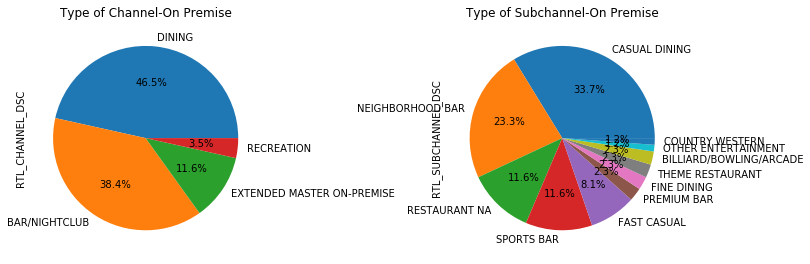

In [70]:
#type channels that change for on premise
channel = onPremise_channel_change_DF.loc[:,'RTL_CHANNEL_DSC'].value_counts()
subchannel = onPremise_channel_change_DF.loc[:,'RTL_SUBCHANNEL_DSC'].value_counts()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
channel.plot(ax=axes[0], kind='pie', autopct='%1.1f%%'); axes[0].set_title('Type of Channel-On Premise')
subchannel.plot(ax=axes[1], kind='pie',autopct='%1.1f%%'); axes[1].set_title('Type of Subchannel-On Premise')
fig.subplots_adjust(left=0.0, bottom=0.1, right=0.9, top=0.9, wspace=0.8, hspace=0.9 )

In [42]:
#see which stores changed channel or sub-channel for on premise
previous_store_num = '0'
off_store_num_list = []
for index in range(len(off_subset_DF)):
    if off_subset_DF.loc[index, 'RTL_TDLINX_STORE_CD'] == previous_store_num:
        if off_subset_DF.loc[index, 'RTL_CHANNEL_DSC'] != off_subset_DF.loc[index-1, 'RTL_CHANNEL_DSC']:
            off_store_num_list.append(previous_store_num)
        elif off_subset_DF.loc[index, 'RTL_SUBCHANNEL_DSC'] != off_subset_DF.loc[index-1, 'RTL_SUBCHANNEL_DSC']:
            off_store_num_list.append(previous_store_num)
    previous_store_num = off_subset_DF.loc[index, 'RTL_TDLINX_STORE_CD']
len(off_store_num_list)

8

In [45]:
#see the stores:
offPremise_channel_change_DF = pd.DataFrame()
for each in off_store_num_list:
    tempDF = off_subset_DF.loc[off_subset_DF['RTL_TDLINX_STORE_CD'] == each]
    frames = [offPremise_channel_change_DF, tempDF]
    offPremise_channel_change_DF = pd.concat(frames)
offPremise_channel_change_DF.head()

,RTL_TDLINX_STORE_CD,RTL_STORE_CD,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_STORE_STTS_DSC,RTL_PREMISE_TYPE_DSC,RTL_ADDR_01_DSC,EQV_QTY_TY,EQV_QTY_YA,EQV_QTY_YA2,TY_BEERTYPE,YA_BEERTYPE,YA2_BEERTYPE
34,0226880,100226880,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,CLOSED STORE,OFF PREMISE,126 W AVENUE A,NaN,NaN,3,NaN,NaN,NaN
35,0226880,200226880,CONVENIENCE STORE,GAS STATION/KIOSK,OPEN STORE,OFF PREMISE,126 W AVENUE A,2,32,5,LowPoint,LowPoint,NaN
98,0472374,100472374,GROCERY,SUPERETTE,CLOSED STORE,OFF PREMISE,129 W RANDOLPH ST,NaN,NaN,4,NaN,NaN,LowPoint
99,0472374,200472374,GROCERY,SUPERETTE,CLOSED STORE,OFF PREMISE,129 W RANDOLPH ST,NaN,2,4,NaN,NaN,NaN
100,0472374,300472374,EXTENDED MASTER OFF-PREMISE,SMALL GROCERY,OPEN STORE,OFF PREMISE,129 W RANDOLPH ST,4,7,NaN,LowPoint,LowPoint,NaN


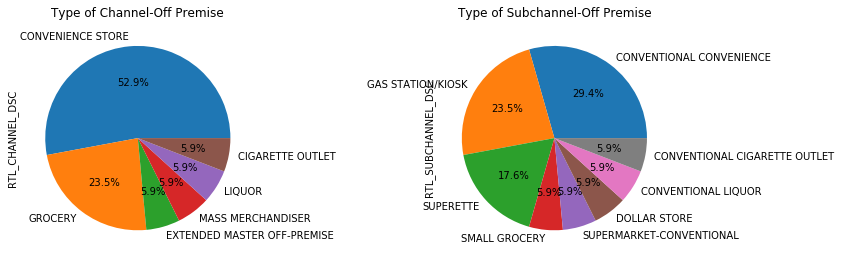

In [67]:
#type channels that change for on premise
channel = offPremise_channel_change_DF.loc[:,'RTL_CHANNEL_DSC'].value_counts()
subchannel = offPremise_channel_change_DF.loc[:,'RTL_SUBCHANNEL_DSC'].value_counts()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
channel.plot(ax=axes[0], kind='pie', autopct='%1.1f%%'); axes[0].set_title('Type of Channel-Off Premise')
subchannel.plot(ax=axes[1], kind='pie',autopct='%1.1f%%'); axes[1].set_title('Type of Subchannel-Off Premise')
fig.subplots_adjust(left=0.0, bottom=0.1, right=0.9, top=0.9, wspace=0.8, hspace=0.9 )

10

In [113]:
#find all the stores that are closed already for both premises 
closed_store_list = []
for each in list(set(subset_DF['RTL_TDLINX_STORE_CD'])):
    tempDF = subset_DF.loc[subset_DF['RTL_TDLINX_STORE_CD'] == each]
    if 'OPEN STORE' not in list(tempDF['RTL_STORE_STTS_DSC']):
        closed_store_list.append(each)

#see the stores:
closed_store_DF = pd.DataFrame()
for each in closed_store_list:
    tempDF = subset_DF.loc[subset_DF['RTL_TDLINX_STORE_CD'] == each]
    frames = [closed_store_DF, tempDF]
    closed_store_DF = pd.concat(frames)
closed_store_DF

#number of on-premise that are closed
on_premise_closed = closed_store_DF.loc[closed_store_DF['RTL_PREMISE_TYPE_DSC'] == 'ON PREMISE']
off_premise_closed = closed_store_DF.loc[closed_store_DF['RTL_PREMISE_TYPE_DSC'] == 'OFF PREMISE']
print 'there are', len(set(on_premise_closed['RTL_TDLINX_STORE_CD'])), 'permanently closed on-premise stores'
#number of off-premise that are closed
print 'there are', len(set(off_premise_closed['RTL_TDLINX_STORE_CD'])), 'permanently closed off-premise stores'


closed_store_DF.head()

there are 8 permanently closed on-premise stores
there are 2 permanently closed off-premise stores


,RTL_TDLINX_STORE_CD,RTL_STORE_CD,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_STORE_STTS_DSC,RTL_PREMISE_TYPE_DSC,RTL_ADDR_01_DSC,EQV_QTY_TY,EQV_QTY_YA,EQV_QTY_YA2,TY_BEERTYPE,YA_BEERTYPE,YA2_BEERTYPE
477,2004267,102004267,DINING,CASUAL DINING,CLOSED STORE,ON PREMISE,116 HARVEST DR,NaN,41.3334,75.7779,NaN,NonLowPoint,NonLowPoint
478,2004267,202004267,DINING,CASUAL DINING,CLOSED STORE,ON PREMISE,116 HARVEST DR,20.6667,13.7778,NaN,NonLowPoint,NaN,NaN
356,1732257,101732257,DINING,CASUAL DINING,CLOSED STORE,ON PREMISE,1701 10TH AVE,NaN,NaN,87.9167,NaN,NaN,NonLowPoint
357,1732257,201732257,DINING,CASUAL DINING,CLOSED STORE,ON PREMISE,1701 10TH AVE,NaN,58.1666,92.3333,NaN,NonLowPoint,NaN
4,0090793,100090793,GROCERY,SUPERMARKET-CONVENTIONAL,CLOSED STORE,OFF PREMISE,506 NORTH ST US HWY 36,NaN,NaN,1,NaN,NaN,NaN


In [115]:
#see if any store that actually changed the beertype (beertype is defined by sql)
previous_store_num = '0'
beerType_store_num_list = []
for index in range(len(subset_DF)):
    if subset_DF.loc[index, 'RTL_TDLINX_STORE_CD'] == previous_store_num:
        if 'LowPoint'in list(subset_DF.loc[index-1, 'TY_BEERTYPE':'YA2_BEERTYPE']) and 'NonLowPoint'in list(subset_DF.loc[index, 'TY_BEERTYPE':'YA2_BEERTYPE']):
            beerType_store_num_list.append(previous_store_num)
        elif 'NonLowPoint'in list(subset_DF.loc[index-1, 'TY_BEERTYPE':'YA2_BEERTYPE']) and 'LowPoint'in list(subset_DF.loc[index, 'TY_BEERTYPE':'YA2_BEERTYPE']):
            beerType_store_num_list.append(previous_store_num)
    previous_store_num = subset_DF.loc[index, 'RTL_TDLINX_STORE_CD']

#see the stores:
beerType_changed_DF = pd.DataFrame()
for each in beerType_store_num_list:
    tempDF = subset_DF.loc[subset_DF['RTL_TDLINX_STORE_CD'] == each]
    frames = [beerType_changed_DF, tempDF]
    beerType_changed_DF = pd.concat(frames)
beerType_changed_DF

,RTL_TDLINX_STORE_CD,RTL_STORE_CD,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_STORE_STTS_DSC,RTL_PREMISE_TYPE_DSC,RTL_ADDR_01_DSC,EQV_QTY_TY,EQV_QTY_YA,EQV_QTY_YA2,TY_BEERTYPE,YA_BEERTYPE,YA2_BEERTYPE
285,1404139,201404139,LIQUOR,CONVENTIONAL LIQUOR,CLOSED STORE,OFF PREMISE,211 N HILLSIDE ST,NaN,21,368,NaN,NaN,NonLowPoint
286,1404139,301404139,CIGARETTE OUTLET,CONVENTIONAL CIGARETTE OUTLET,OPEN STORE,OFF PREMISE,211 N HILLSIDE ST,13,NaN,NaN,LowPoint,NaN,NaN
451,1948871,101948871,DINING,CASUAL DINING,CLOSED STORE,ON PREMISE,850 S COLORADO ST,NaN,16.9166,306.333,NaN,NaN,LowPoint
452,1948871,201948871,LIQUOR,CONVENTIONAL LIQUOR,OPEN STORE,OFF PREMISE,850 S COLORADO ST,529.416,704.333,NaN,NonLowPoint,NonLowPoint,NaN
469,1989706,101989706,DINING,CASUAL DINING,CLOSED STORE,ON PREMISE,245 N MAIN ST,NaN,2,42.7776,NaN,NaN,NonLowPoint
470,1989706,201989706,DINING,CASUAL DINING,OPEN STORE,ON PREMISE,245 N MAIN ST,21,24.5,NaN,LowPoint,LowPoint,NaN
557,5526362,105526362,DINING,THEME RESTAURANT,CLOSED STORE,ON PREMISE,11900 METCALF AVE,NaN,NaN,5.5,NaN,NaN,NaN
558,5526362,205526362,DINING,CASUAL DINING,CLOSED STORE,ON PREMISE,11900 METCALF AVE,NaN,9.3888,NaN,NaN,NonLowPoint,NaN
559,5526362,305526362,DINING,FINE DINING,OPEN STORE,ON PREMISE,11900 METCALF AVE,3.4444,6.9444,NaN,LowPoint,NaN,NaN


In [119]:
beerType_changed_DF.shape

(9, 13)

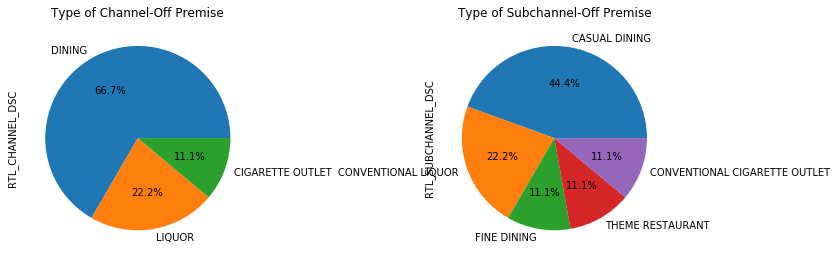

In [117]:
#type channels that change for on premise
channel = beerType_changed_DF.loc[:,'RTL_CHANNEL_DSC'].value_counts()
subchannel = beerType_changed_DF.loc[:,'RTL_SUBCHANNEL_DSC'].value_counts()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
channel.plot(ax=axes[0], kind='pie', autopct='%1.1f%%'); axes[0].set_title('Type of Channel-Off Premise')
subchannel.plot(ax=axes[1], kind='pie',autopct='%1.1f%%'); axes[1].set_title('Type of Subchannel-Off Premise')
fig.subplots_adjust(left=0.0, bottom=0.1, right=0.9, top=0.9, wspace=0.8, hspace=0.9)